In [1]:
import os

import numpy as np
from netCDF4 import Dataset
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 

In [2]:
jedi_obs_file = "/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/2023061012/ioda_adpsfc_dc.nc"
#jedi_obs_file = "/work/noaa/wrfruc/span/jedi_summer_retro/observations/2023061012/ioda_msonet.nc"
itype=287
variable = "windNorthward"

colormap="coolwarm"

In [3]:
def read_obs(filename, varname):
    # Load the NetCDF file
    nc_data = Dataset(filename, "r")

    # Extract latitude, longitude, and values
    lats = nc_data.groups["MetaData"].variables["latitude"][:]
    lons = nc_data.groups["MetaData"].variables["longitude"][:]
    times = nc_data.groups["MetaData"].variables["timeOffset"][:]
    press = nc_data.groups["MetaData"].variables["pressure"][:]
    height = nc_data.groups["MetaData"].variables["height"][:]
    absoffsets = np.abs(nc_data.groups["MetaData"].variables["timeOffset"][:])
    dtypes = nc_data.groups["ObsType"].variables[varname][:]
    values = nc_data.groups["ObsValue"].variables[varname][:]
    qcflags = nc_data.groups["QualityMarker"].variables[varname][:]
    if varname in ["specificHumidity", ]:
        values = values * 1000

    return lats, lons, times, press, height, dtypes, qcflags, absoffsets, values

In [4]:
def find_duplicates(df):
    # Calculate absolute values of 'times'
    #df['abs_times'] = df['times'].abs()
    df_cleaned = df.dropna(subset=[variable])

    df_filtered = df_cleaned[df_cleaned['dtypes'] == itype]
    df_filtered = df_filtered[df_filtered['qcflags'] <= 2]
    df_filtered = df_filtered[df_filtered['absoffsets'] <= 0.25]
    print(df_filtered[:100])
    
    # Sort dataframe by 'abs_times' within each group of 'lats' and 'lons'
    df_sorted = df_cleaned.sort_values(by=['lats', 'lons', 'times'])
    
    # Identify duplicates based on 'lats' and 'lons'
    duplicates = df_sorted[df_sorted.duplicated(subset=['lats', 'lons', 'times'], keep=False)]
    
    #print(duplicates)
    
    ## Drop the 'abs_times' column
    #df_unique = df_unique.drop(columns=['abs_times'])
    #
    ## Sort by index
    #df_unique = df_unique.sort_index().reset_index(drop=True)
    #
    #df_array = df_unique.to_numpy()
    #lats = df_array[:,0]
    #lons = df_array[:,1]
    #times = df_array[:,2]
    #press = df_array[:,3]
    #
    #return lats, lons, times, press, df_unique

In [5]:
def variable_scatter(lons, lats, values, colormap="terrain", markersize=1.0, alpha=1.0,
                     minval=None, maxval=None, area=[-140, -50, 20, 60], clon=-95, clat=40,
                     system=None, varname=None, vartype=None, is_hofx=False):
    fig = plt.figure(figsize=(20, 16))

    cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                       standard_parallels=(clat-5, clat+5))
    #projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    ax = plt.axes(projection=projection)
    ax.set_extent(area, crs=ccrs.PlateCarree())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, zorder=0)
    
    # Add coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
    ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Add country borders
    countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
    ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)
    
    # Add state lines
    states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

    sc = ax.scatter(lons, lats, c=values, cmap=colormap, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), s=markersize, alpha=alpha)

    # Calculate the min and max of the values array
    n_obs = values.shape[0]
    min_value = np.min(values)
    max_value = np.max(values)
    mean_value = np.mean(values)
    stdev_value = np.std(values)

    # Add text for the min and max values in the bottom left corner of the map
    text_str = f"Number of Obs: {n_obs:4}\nMin Value: {min_value:.4f} \
                 \nMax Value: {max_value:.4f}\nMean Value: {mean_value:.4f} \
                 \nStandard Deviation: {stdev_value:.4f}"
    ax.text(area[0] + 1, area[2] - 1, text_str, transform=ccrs.PlateCarree(),
            fontsize=18, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add a colorbar at the bottom
    if "Errinv" in vartype:
        cblabel = system + " " + varname + " 1/" + vartype
    else:
        if is_hofx:
            cblabel = system + " " + varname + " HofX"
        else:
            cblabel = system + " " + varname + " " + vartype
    cbar = plt.colorbar(sc, label=cblabel, orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)

          lats        lons       times     press  height  dtypes  qcflags  absoffsets  windNorthward
170  24.549999  278.250000 -839.987976  101210.0     NaN     287      2.0     0.23333            0.0
172  24.549999  278.250000 -420.011993  101210.0     NaN     287      2.0     0.11667            0.0
174  24.570000  278.320007 -420.011993  101200.0     NaN     287      2.0     0.11667            0.0
176  24.730000  278.950012 -420.011993  101170.0     NaN     287      2.0     0.11667            0.0
178  25.049999  282.529999    0.000000  101210.0     NaN     287      2.0     0.00000            1.8
180  25.650000  279.570007 -420.011993  101180.0     NaN     287      2.0     0.11667            0.0
182  25.770000  262.470001 -420.011993  100850.0     NaN     287      2.0     0.11667            1.4
186  25.790001  279.709991 -420.011993  101170.0     NaN     287      2.0     0.11667           -2.9
188  25.900000  262.570007 -420.011993  100880.0     NaN     287      2.0     0.11667      

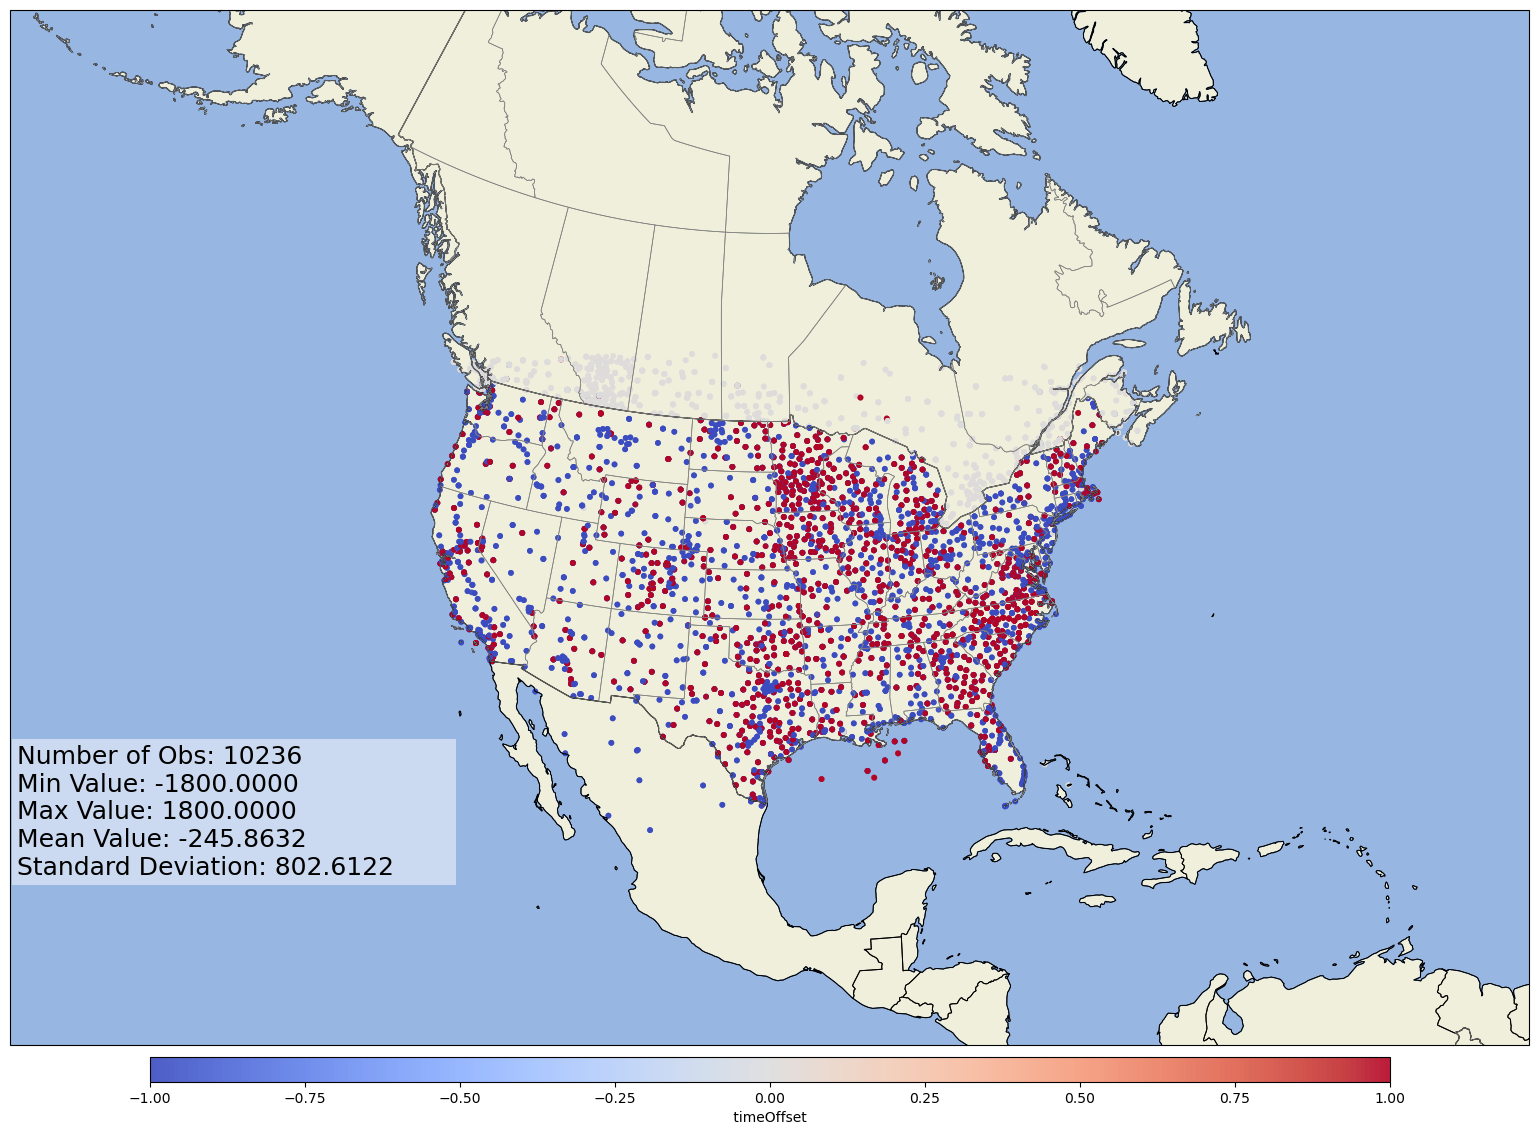

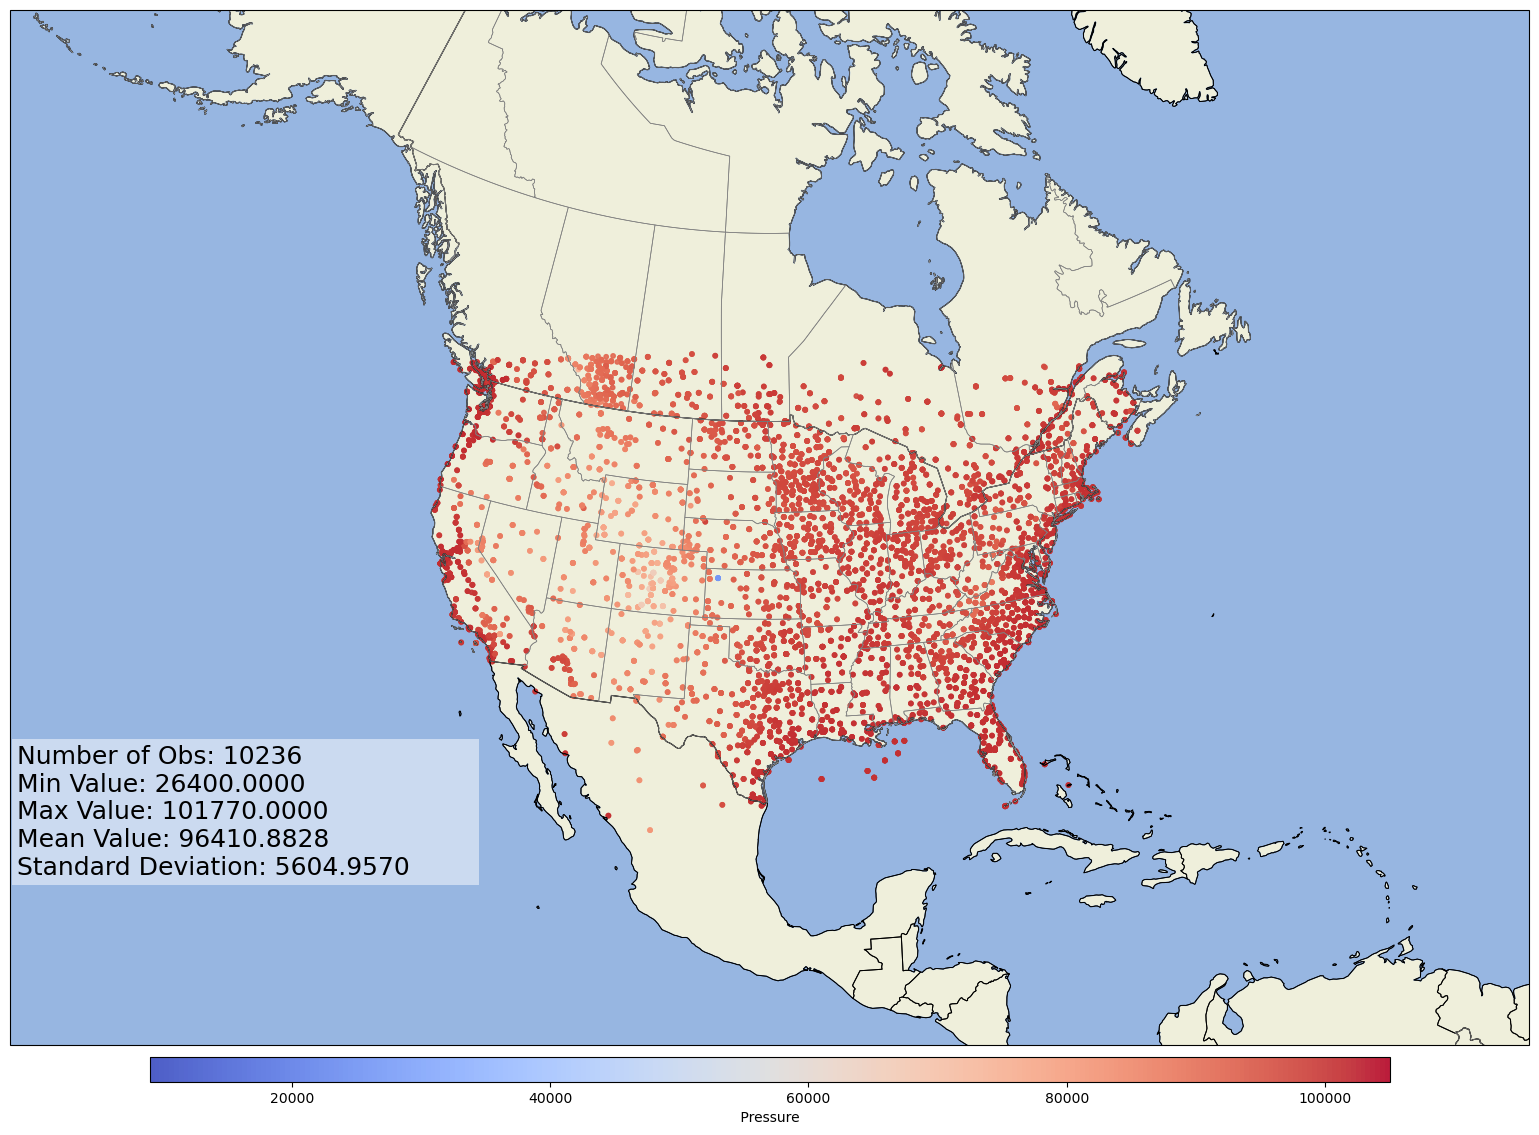

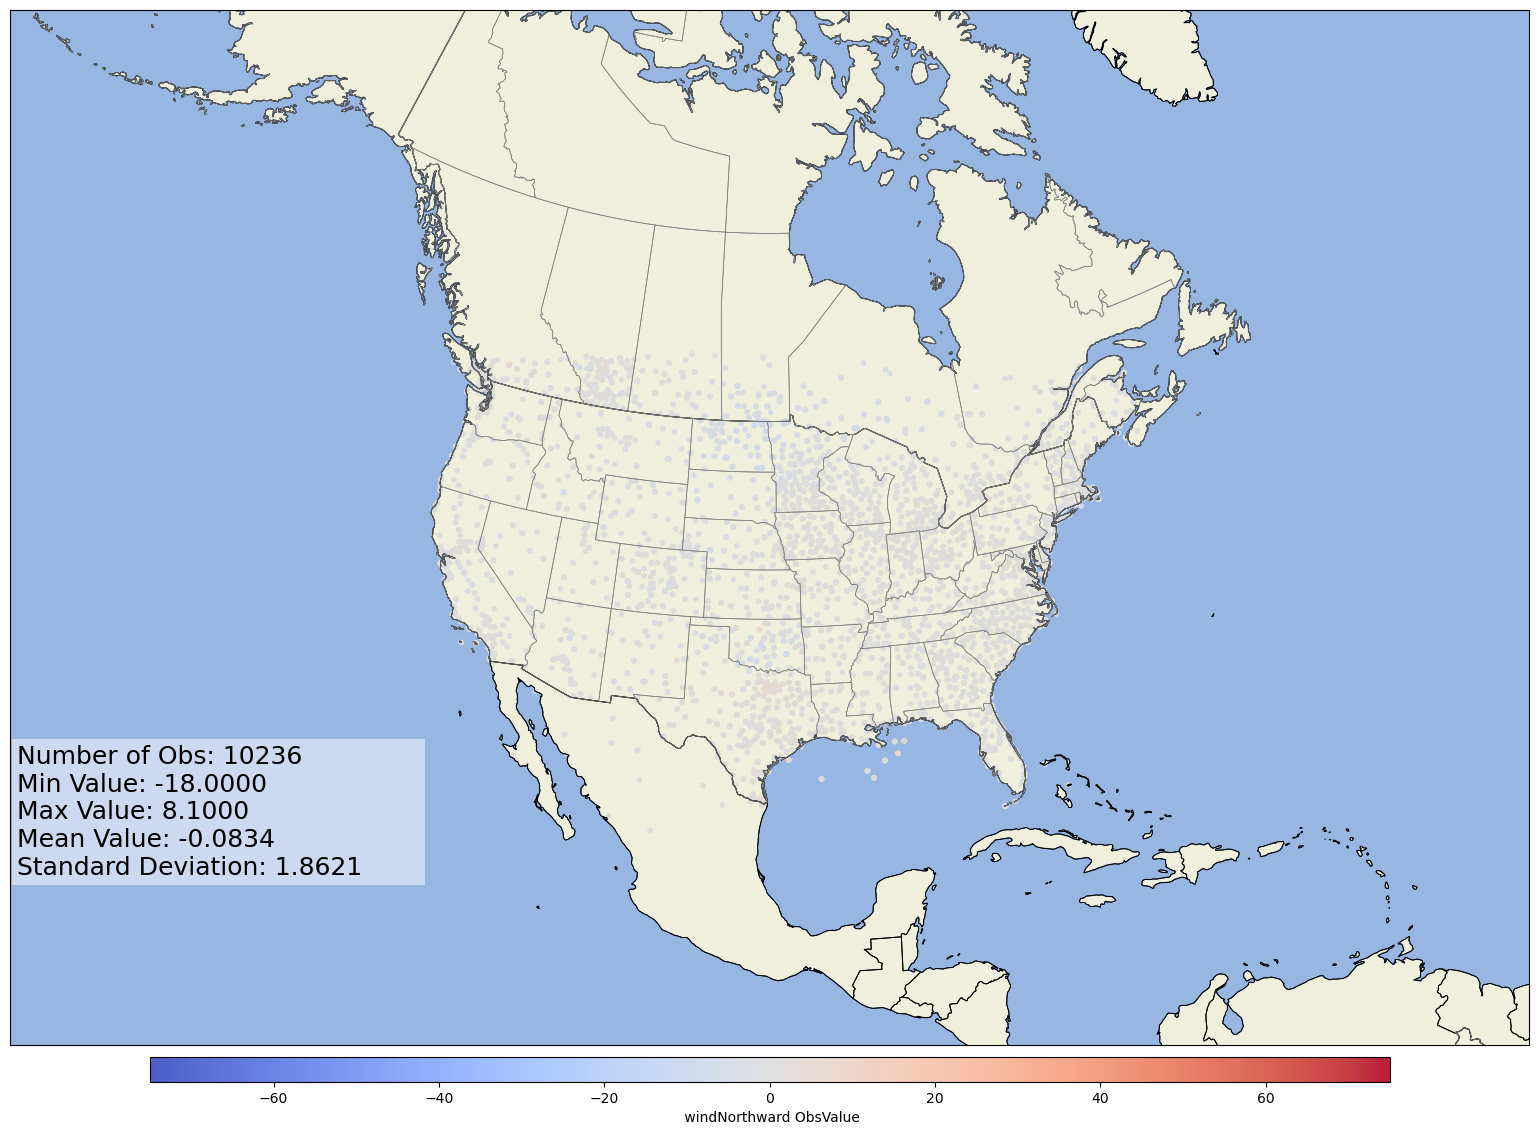

In [6]:
lats, lons, times, press, height, dtypes, qcflags, absoffsets, values = read_obs(jedi_obs_file, variable)
times = times * 3600

obs = pd.DataFrame({'lats': lats, 'lons': lons, 'times': times,
                    'press': press, 'height': height, 'dtypes': dtypes, 
                    'qcflags': qcflags, 'absoffsets': absoffsets, variable: values})

find_duplicates(obs)

maxlat = 68
minlat = 12
maxlon = -53
minlon = -141

maxval = 1
minval = -1
variable_scatter(lons, lats, times, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                 system="", varname="timeOffset", vartype="", is_hofx=False)

maxval = 10000
minval = 105000
variable_scatter(lons, lats, press, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                 system="", varname="Pressure", vartype="", is_hofx=False)

maxval = 75
minval = -75
variable_scatter(lons, lats, values, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                 area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                 system="", varname=variable, vartype="ObsValue", is_hofx=False)